In [2]:
# imports

import platform
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import jinja2
import numpy as np

print('python: {}'.format(platform.python_version()))
print('matplotlib: {}'.format(matplotlib.__version__))

python: 3.12.1
matplotlib: 3.5.2


# BRAINLY recruitment task:
#### Research the frequency distributions of total answers read per user in the Brainly App for 2 segments: users who converted to trial vs users who didn't convert.

#### In this analysis, please aggregate the answers read in the first 7 days of user activity. Take into account only the users who had their first session between September 23rd and September 29th.

## SQL query 
#### that generated data.csv

In [ ]:
"""
WITH
    user_first_7days_activity AS (
        SELECT
            *
        FROM
            SQL_TEST.SANDBOX.COHORT_ACTIVITY_RAW
        WHERE 
            user_first_visit_date BETWEEN DATE('2019-09-23') AND DATE('2019-09-29')
            AND DATEDIFF(DAY, user_first_visit_date, action_date) <=6
        QUALIFY DENSE_RANK() OVER (PARTITION BY user_pseudo_id ORDER BY user_trial_conversion_date) = 1 --taking records only for the first conversion date (duplicates exclusion)
    ),

    data AS (
        SELECT
            user_pseudo_id,
            user_converted_to_trial,
            CASE WHEN DATEDIFF(DAY, user_first_visit_date, user_trial_conversion_date) <=6 THEN 1 ELSE 0 END AS user_converted_to_trial_in7d,
            SUM(read_an_answer_count) AS answers_read_sum,
            SUM(CASE WHEN hit_is_logged=1 THEN read_an_answer_count ELSE 0 END) AS logged_answers_read_sum,
            SUM(ocr_searches_count+text_searches_count+voice_searches_count) AS searches_sum,
            SUM(questions_added_count) AS question_added_sum,
            SUM(answers_added_count) AS answers_added_sum,
            COUNT(DISTINCT action_date) AS days_active_usage
        FROM
            user_first_7days_activity
        GROUP BY
            1, 2, 3  
    )

-- *** data for histogram (Python)
SELECT * from data
"""

In [3]:
# read data generated with above SQL query
df = pd.read_csv('data.csv')
df.head()

,USER_PSEUDO_ID,USER_CONVERTED_TO_TRIAL,USER_CONVERTED_TO_TRIAL_IN7D,ANSWERS_READ_SUM,LOGGED_ANSWERS_READ_SUM,SEARCHES_SUM,QUESTION_ADDED_SUM,ANSWERS_ADDED_SUM,DAYS_ACTIVE_USAGE
0,M7GHMQeiUALzksZNxKNEakslP9w=,0,0,0,0,0,0,0,1
1,b98FwkxwPpk88cNI9BSdQsP3834=,0,0,0,0,1,0,0,1
2,glfts7sFivGoqcei1PLwvpQbjQs=,0,0,0,0,2,0,0,1
3,bSGS0mAgY8DC6fvCaziUcGAZD40=,0,0,0,0,1,0,0,2
4,vLfZOFFm++b4s9OCZxuVGMyTifw=,0,0,0,0,2,0,0,1


## DEFINITION
##### * USER_CONVERTED_TO_TRIAL: 1 = user has converted; 0 = user hasn't converted to trial during whole available period (all data from database)
##### * USER_CONVERTED_TO_TRIAL_IN7D: 1 = user has converted; 0 = user hasn't converted to trial in first 7 days from first visit
##### * ANSWERS_READ_SUM: total number of answer read
##### * LOGGED_ANSWERS_READ_SUM: total number of answer read while logged in
##### * SEARCHES_SUM: total number of searches (text, OCR and voice)
##### * QUESTION_ADDED_SUM: total number of added questions
##### * ANSWERS_ADDED_SUM: total number of added answers
##### * DAYS_ACTIVE_USAGE: number of days when user was using platform

#### ***************************************************************************************************************************************************************************************************

In [4]:
# calculating counts for each segment
def calculate_counts(conv_column):

    df_group = df.groupby([conv_column]).ANSWERS_READ_SUM.agg(['count', 'sum'])
    df_group['% users count'] = df_group['count'] / df_group['count'].sum()
    df_group['% answears read'] = df_group['sum'] / df_group['sum'].sum()
    df_group.rename(columns={'count':'users count', 'sum':'answears read sum'}, inplace=True)
    
    display(df_group.style \
      .format({'% users count':'{:.2%}', 
               '% answears read':'{:.2%}'},
              thousands=","
             ))

# plot histograms on seperate plots
def plot_histogram_subplots(density_value, ylable_value, conv_df, not_conv_df, metric_column):
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.suptitle('Answears read distribution')
    
    ax1.hist(not_conv_df, label='not converted', density=density_value, color='lightblue', bins=50)
    ax2.hist(conv_df, label='converted', density=density_value, color='royalblue', bins=50)
    
    ax1.set_title('Not converted users')
    ax2.set_title('Converted users')
    
    ax1.set_xlabel(metric_column)
    ax2.set_xlabel(metric_column)
    ax1.set_ylabel(ylable_value)
    ax2.set_ylabel(ylable_value)
    
    plt.show()
    
# calculate distribution stats for selected metric
def summary_for_metric(conv_column, metric_column):
    # define dataframe slices for converted and not converted users
    conv = df.loc[df[conv_column] == 1, metric_column]
    not_conv = df.loc[df[conv_column] == 0, metric_column]

    # printing distribution stats
    print('\n\n', 
           f'\033[1mDistribution stats for {metric_column}:\033[0m')
    display(df.groupby(conv_column)[metric_column].describe()
            .style.format(precision=0, thousands=",")
           )

    # plotting density histograms for converted and not converted users on one chart
    
    plt.hist(conv, label='converted', density=True, color='royalblue', bins=50)
    plt.hist(not_conv, label='not converted', density=True, color='lightblue', alpha=0.5, bins=50)
    
    plt.title('Distribution by conversion to trial')
    plt.xlabel(metric_column)
    plt.ylabel('Density')
    
    plt.legend()
    
    plt.show()

    # plotting density histograms for converted and not converted users on separate charts
    plot_histogram_subplots(True, 'Density', conv, not_conv, metric_column)

    # plotting histograms of nominal values for converted and not converted users
    plot_histogram_subplots(False, 'Users count', conv, not_conv, metric_column)

#### ***************************************************************************************************************************************************************************************************
#### Calculating distribution stats for total number of answer read



 Distribution stats for ANSWERS_READ_SUM:


,count,mean,std,min,25%,50%,75%,max
USER_CONVERTED_TO_TRIAL,,,,,,,,
0,"34,372",8,23,0,0,1,7,"1,002"
1,261,31,22,0,17,29,40,125


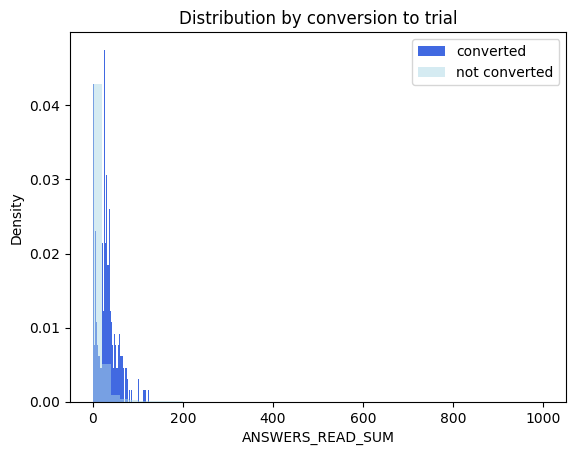

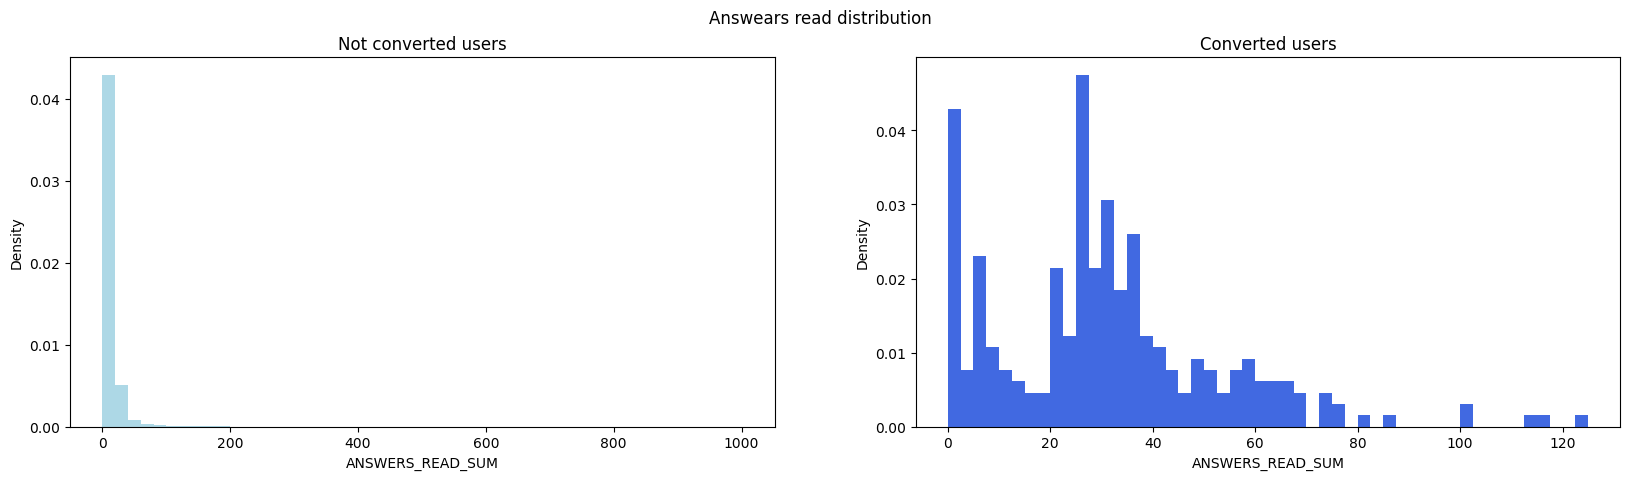

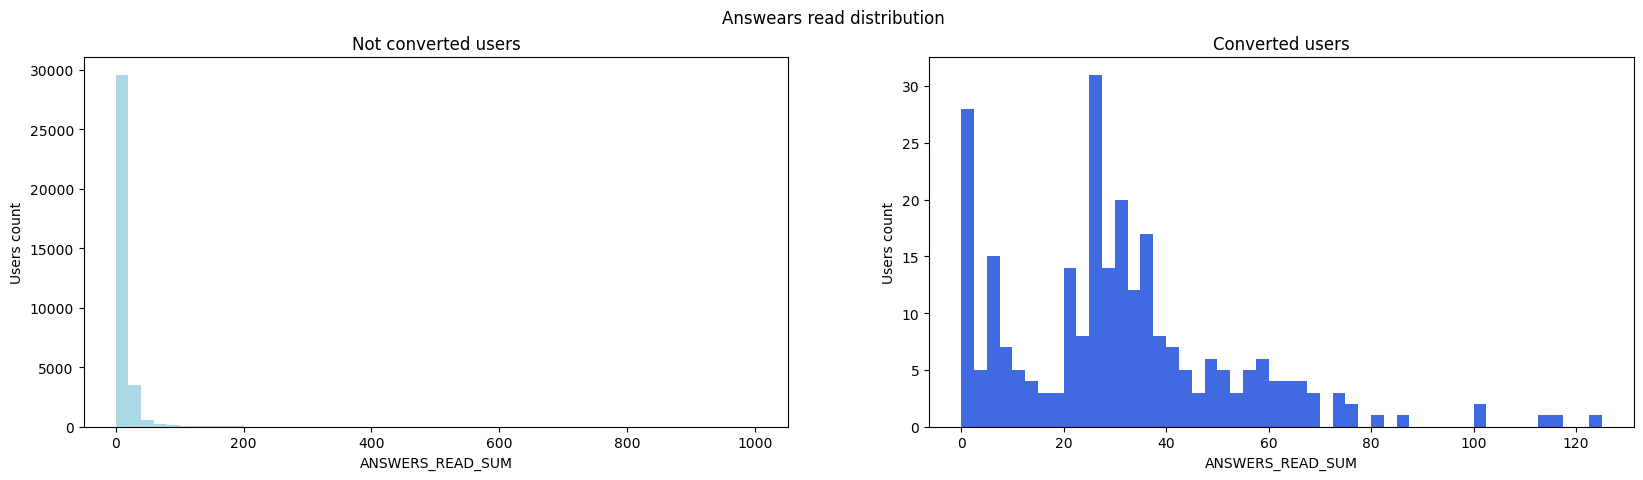

In [5]:
summary_for_metric('USER_CONVERTED_TO_TRIAL', 'ANSWERS_READ_SUM')

#### ***************************************************************************************************************************************************************************************************
#### Calculating share of users that had no or only one answer read

In [6]:
ar_conditions = [
    (df['ANSWERS_READ_SUM'] == 0),
    (df['ANSWERS_READ_SUM'] == 1),
    (df['ANSWERS_READ_SUM'] > 1)
]

ar_values = ['0', '1', '2+']

df['ANSWERS_READ_SUM_GR'] = np.select(ar_conditions, ar_values)
df_group = df.groupby(['USER_CONVERTED_TO_TRIAL', 'ANSWERS_READ_SUM_GR']).USER_PSEUDO_ID.agg(['count'])
df_group['% users count'] = df_group['count'] / df_group.groupby('USER_CONVERTED_TO_TRIAL')['count'].transform('sum')
df_group.rename(columns={'count':'users count'}, inplace=True)

print('\n\n', 
      '\033[1mShare of users that had none or only one answer read in analysed period:\033[0m \n', 
      '\033[1mANSWERS_READ_SUM_GR = \033[0m sum of total answer reads per user (grouped) \n\n'
     )
df_group.style \
  .format({'% users count':'{:.2%}'}, 
          thousands=","
         ) 




 Share of users that had none or only one answer read in analysed period: 
 ANSWERS_READ_SUM_GR =  sum of total answer reads per user (grouped) 




#### ***************************************************************************************************************************************************************************************************
#### Calculating distribution stats for total number of answer read while logged in



 Distribution stats for LOGGED_ANSWERS_READ_SUM:


,count,mean,std,min,25%,50%,75%,max
USER_CONVERTED_TO_TRIAL,,,,,,,,
0,"34,372",7,21,0,0,0,4,"1,002"
1,261,28,23,0,8,26,39,125


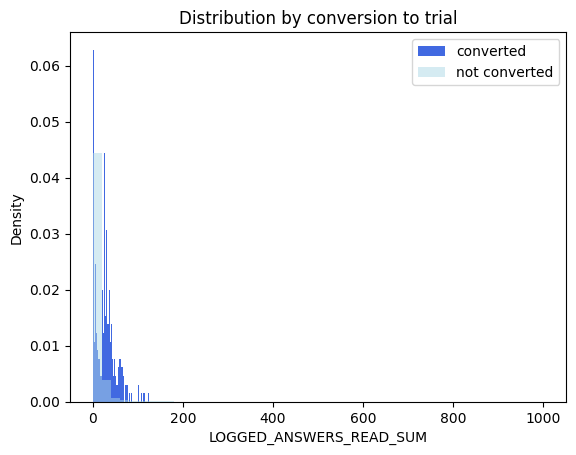

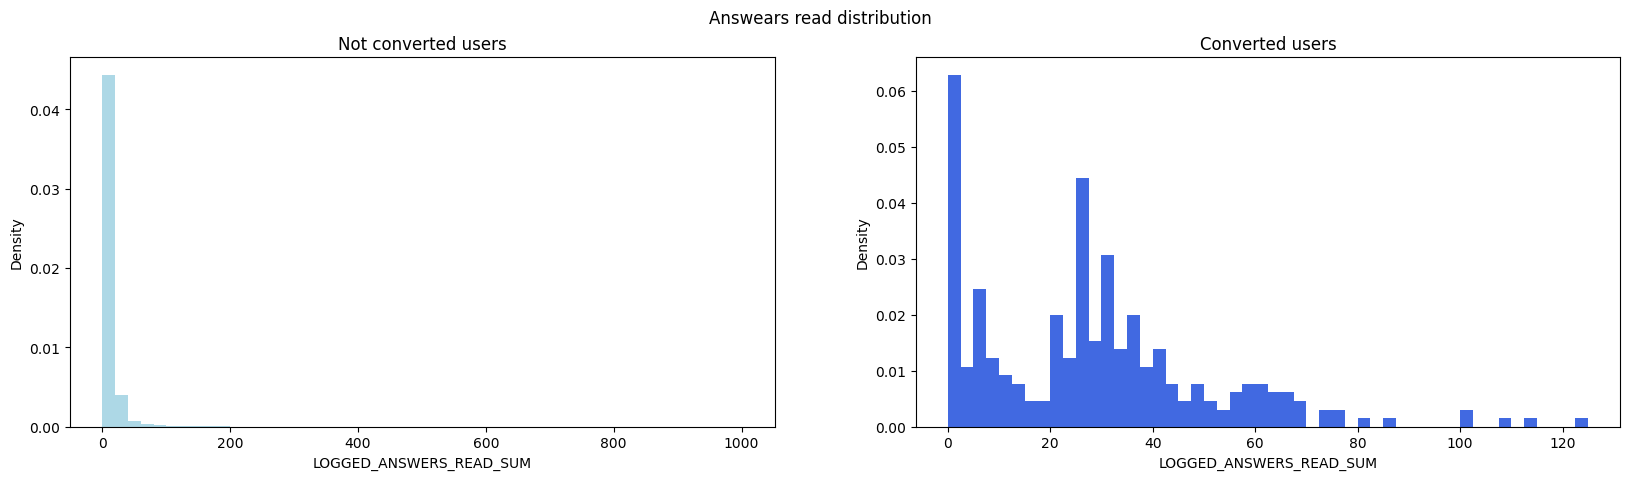

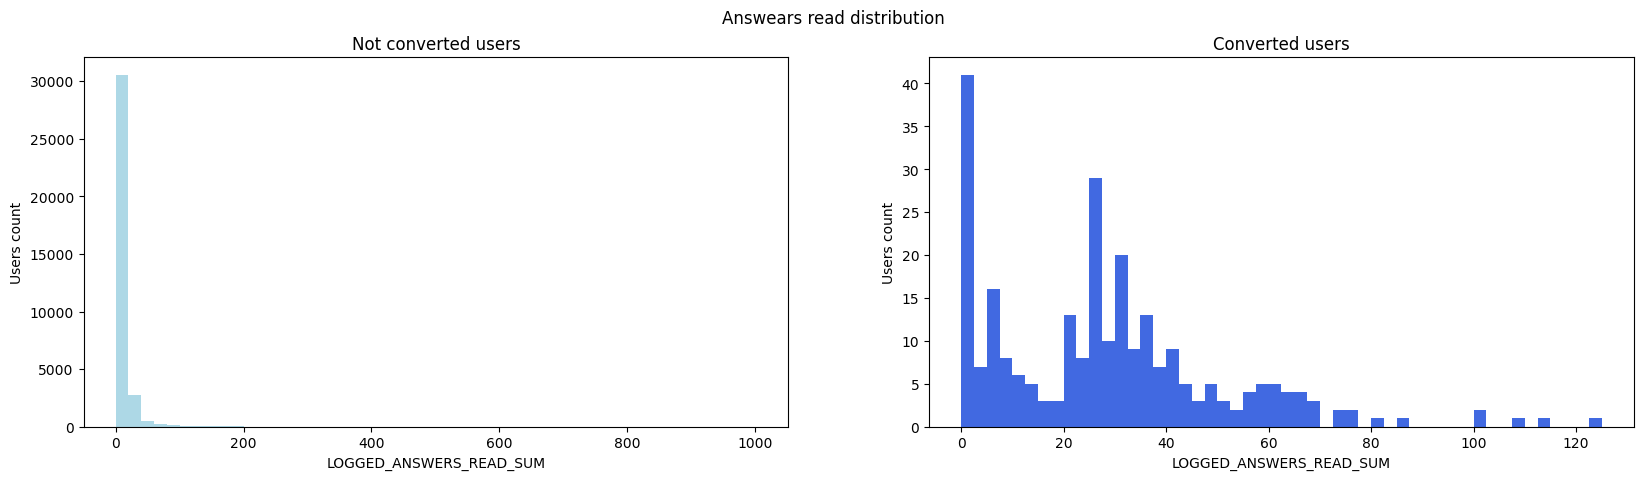

In [7]:
summary_for_metric('USER_CONVERTED_TO_TRIAL', 'LOGGED_ANSWERS_READ_SUM')

#### ***************************************************************************************************************************************************************************************************
#### Calculating distribution stats for total number of searches (text, OCR and voice)



 Distribution stats for SEARCHES_SUM:


,count,mean,std,min,25%,50%,75%,max
USER_CONVERTED_TO_TRIAL,,,,,,,,
0,"34,372",7,20,0,0,2,6,889
1,261,23,21,0,5,21,34,128


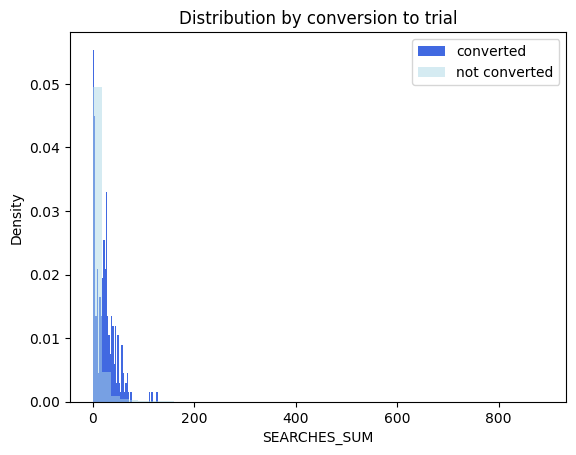

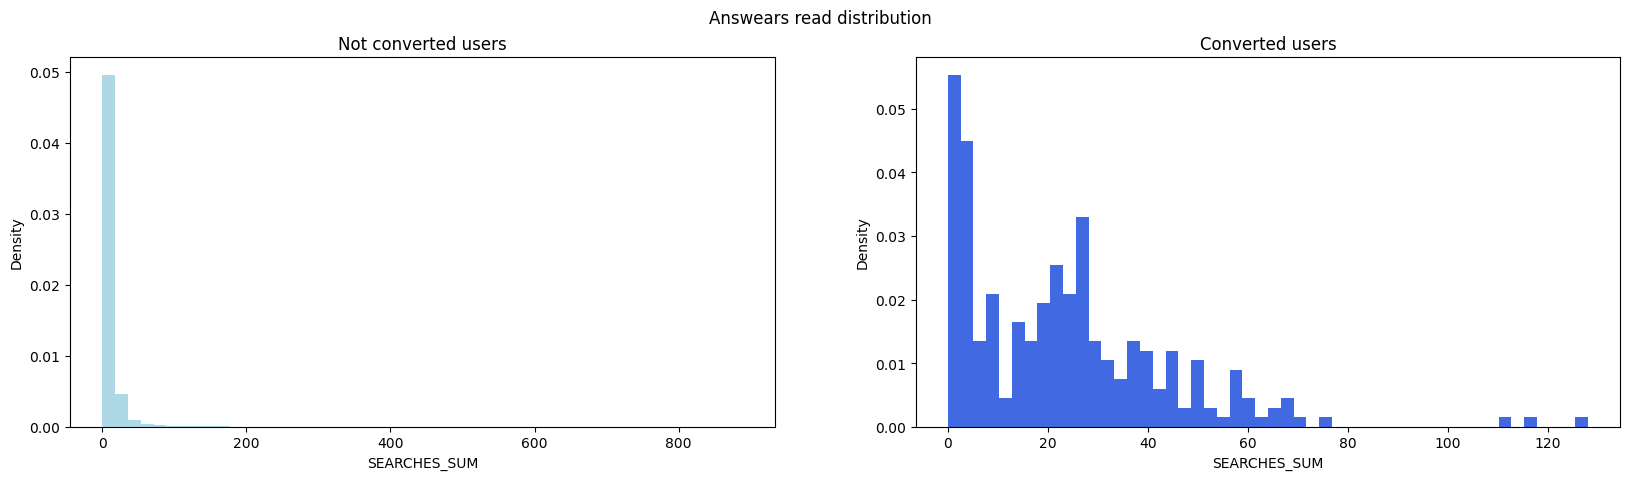

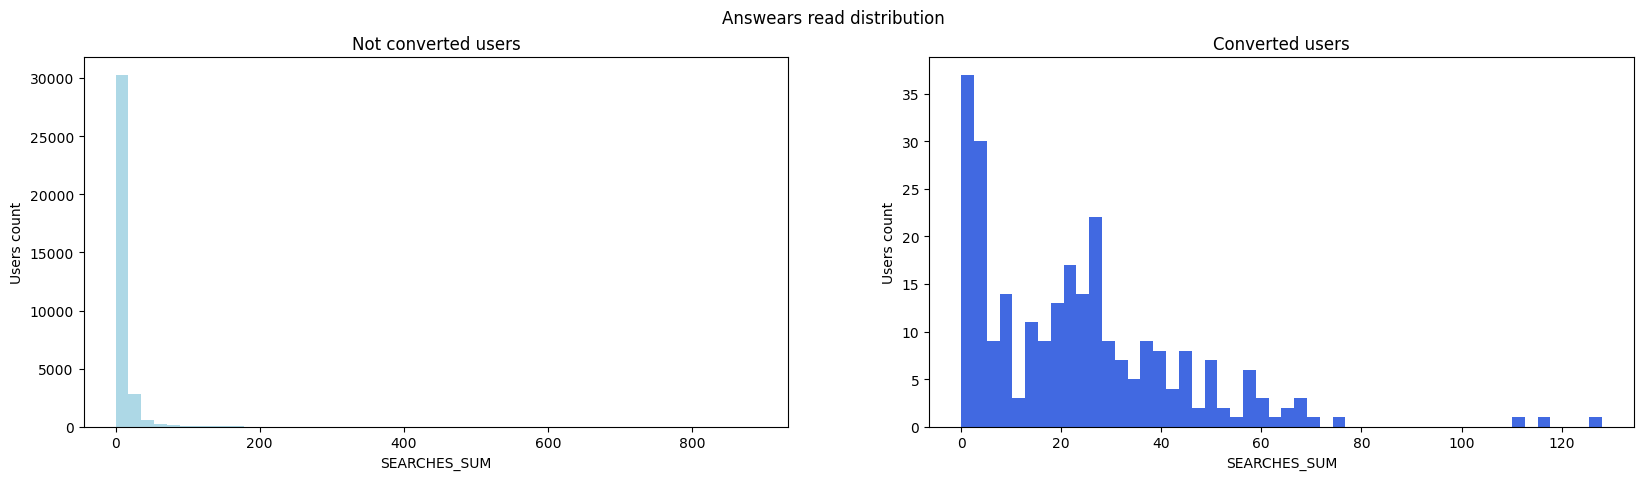

In [8]:
summary_for_metric('USER_CONVERTED_TO_TRIAL', 'SEARCHES_SUM')

#### ***************************************************************************************************************************************************************************************************
#### Calculating distribution stats for total number of added questions



 Distribution stats for QUESTION_ADDED_SUM:


,count,mean,std,min,25%,50%,75%,max
USER_CONVERTED_TO_TRIAL,,,,,,,,
0,"34,372",0,1,0,0,0,0,27
1,261,0,0,0,0,0,0,3


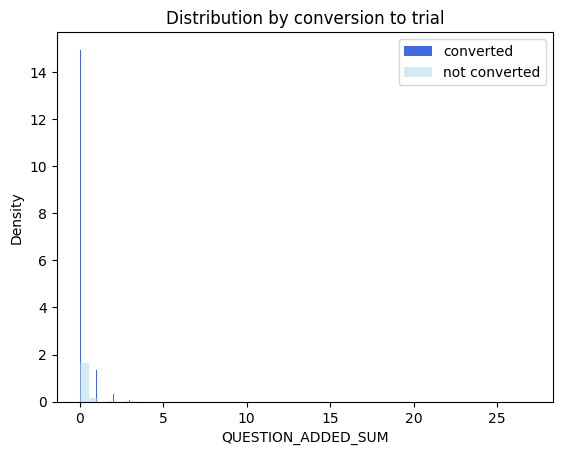

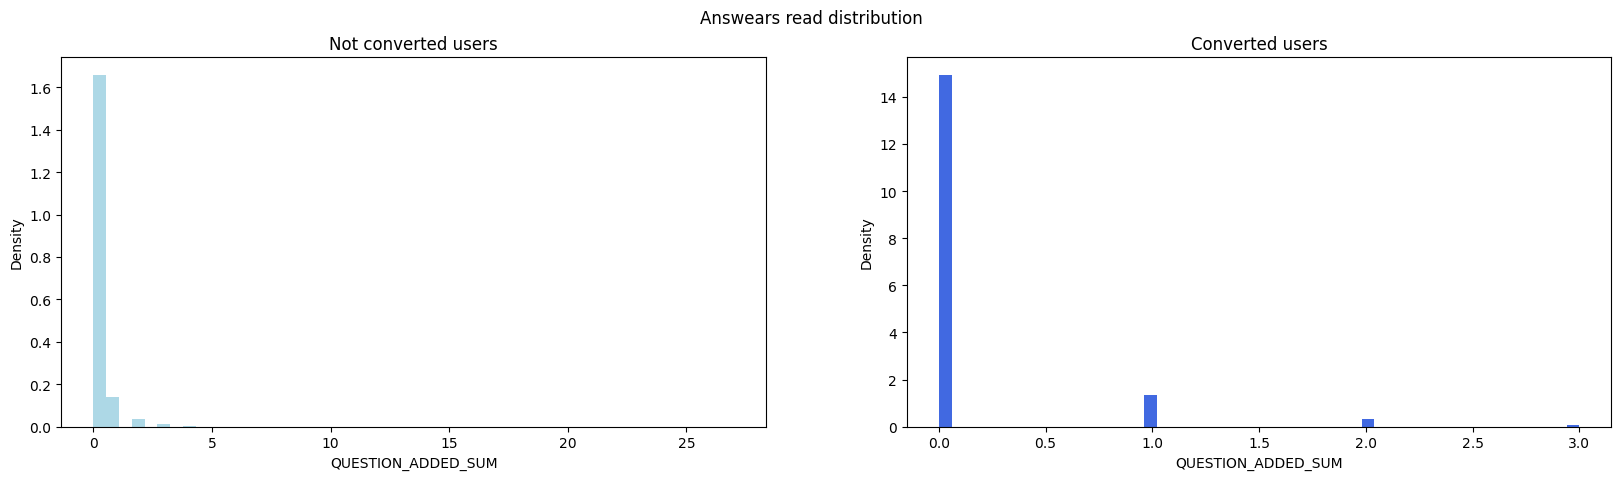

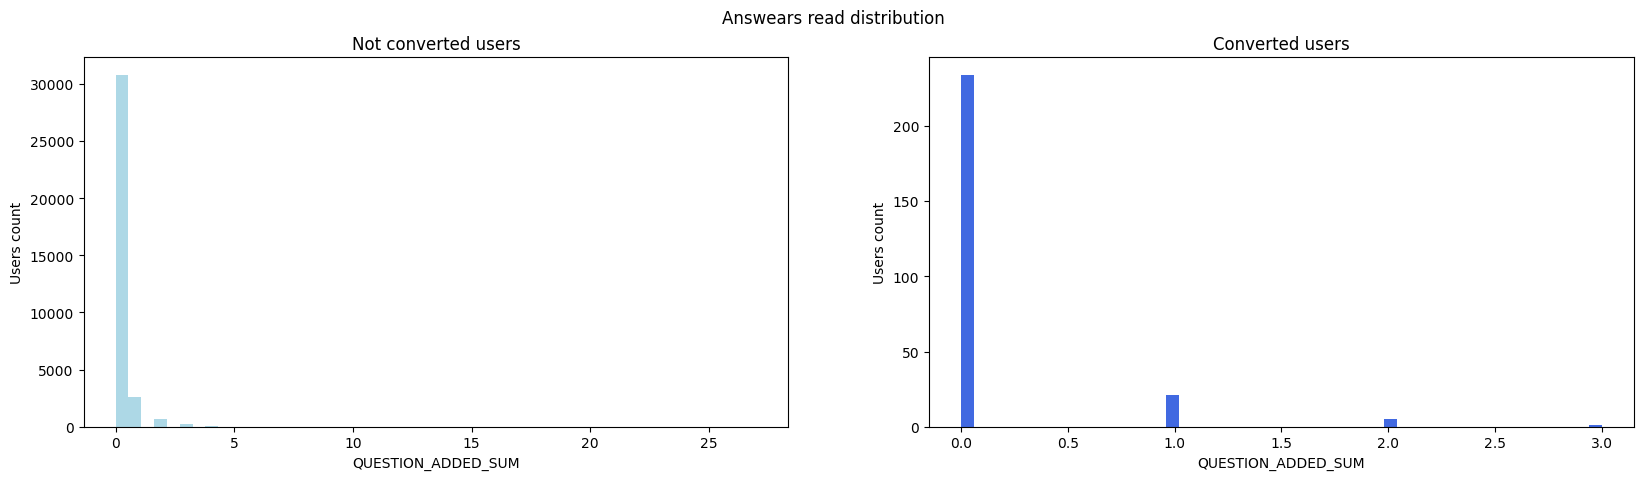

In [9]:
summary_for_metric('USER_CONVERTED_TO_TRIAL', 'QUESTION_ADDED_SUM')

#### ***************************************************************************************************************************************************************************************************
#### Calculating distribution stats for total number of added answers



 Distribution stats for ANSWERS_ADDED_SUM:


,count,mean,std,min,25%,50%,75%,max
USER_CONVERTED_TO_TRIAL,,,,,,,,
0,"34,372",0,1,0,0,0,0,36
1,261,0,0,0,0,0,0,1


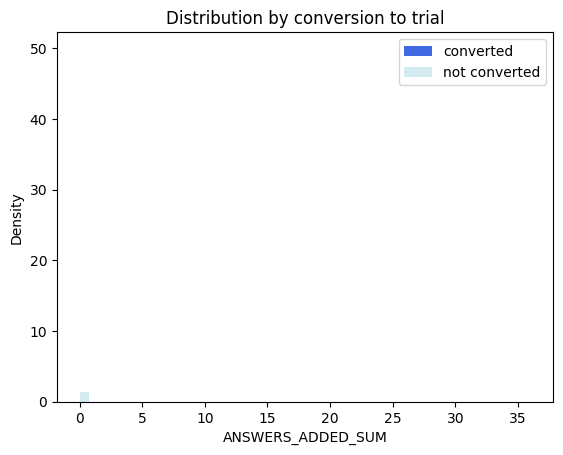

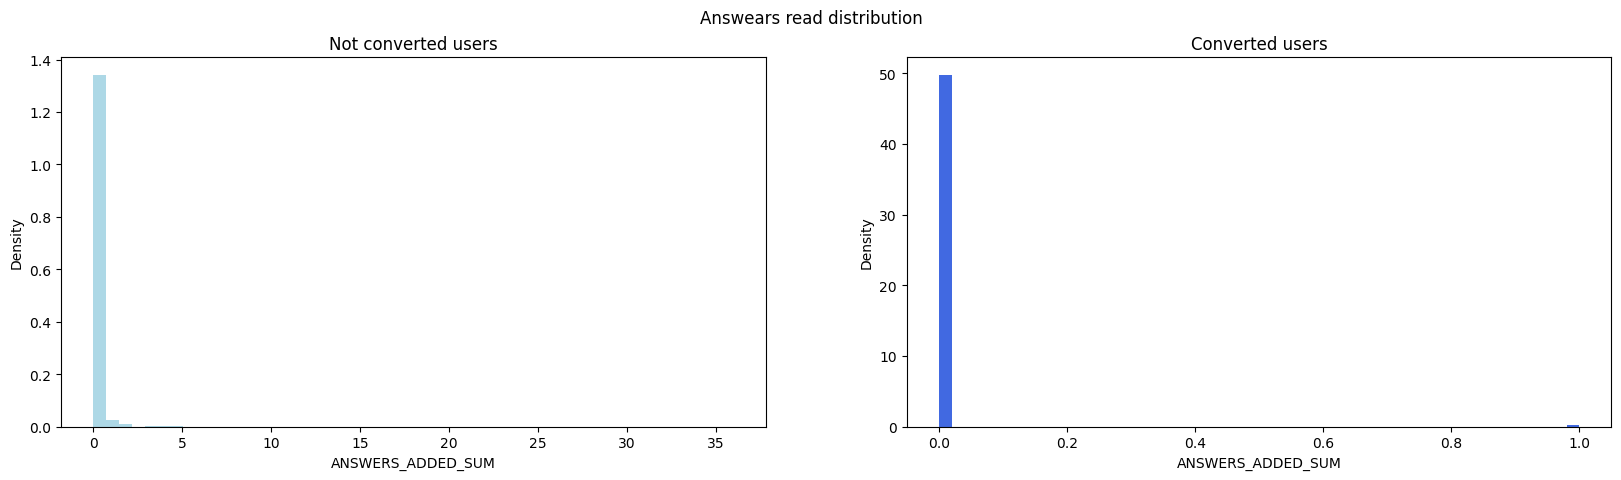

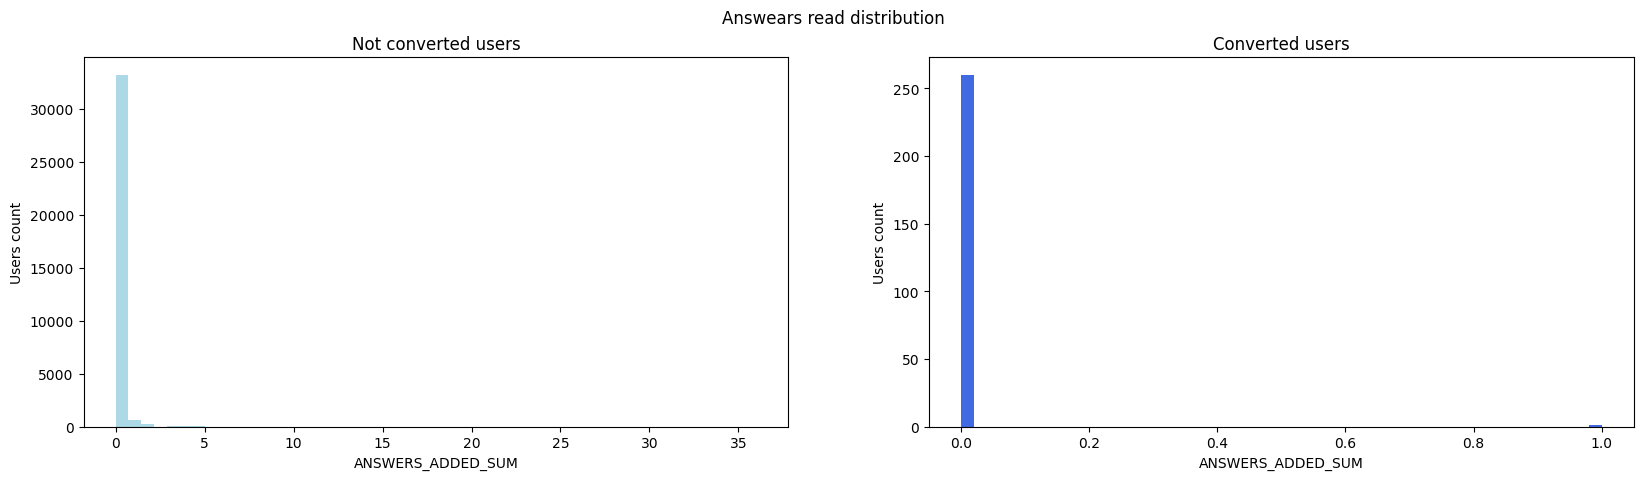

In [10]:
summary_for_metric('USER_CONVERTED_TO_TRIAL', 'ANSWERS_ADDED_SUM')

#### ***************************************************************************************************************************************************************************************************
#### Calculating distribution stats for number of days when user was using platform



 Distribution stats for DAYS_ACTIVE_USAGE:


,count,mean,std,min,25%,50%,75%,max
USER_CONVERTED_TO_TRIAL,,,,,,,,
0,"34,372",2,1,1,1,1,2,7
1,261,2,1,1,1,2,3,6


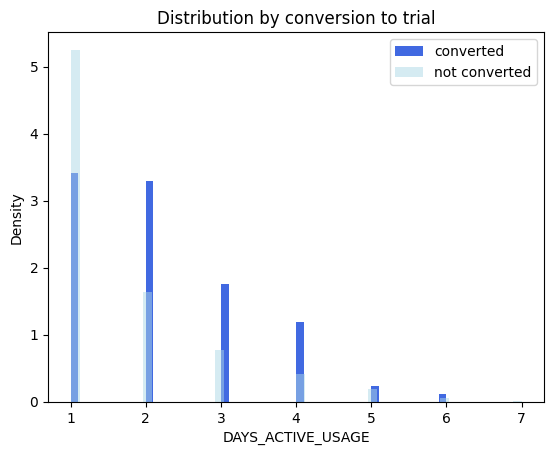

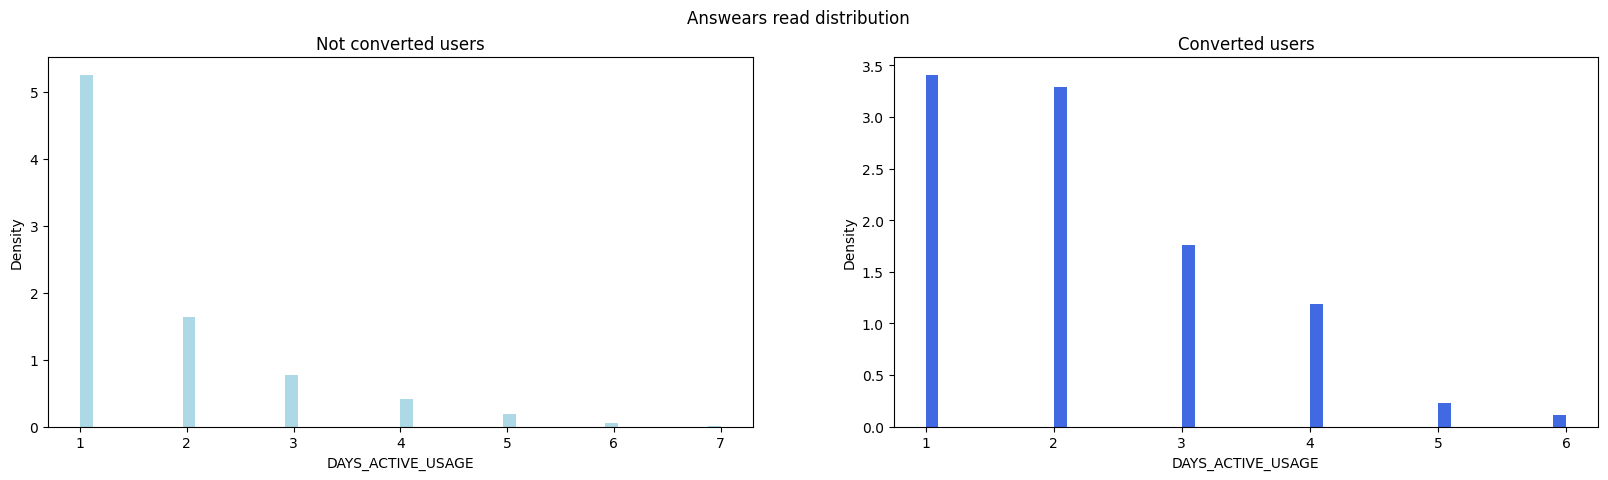

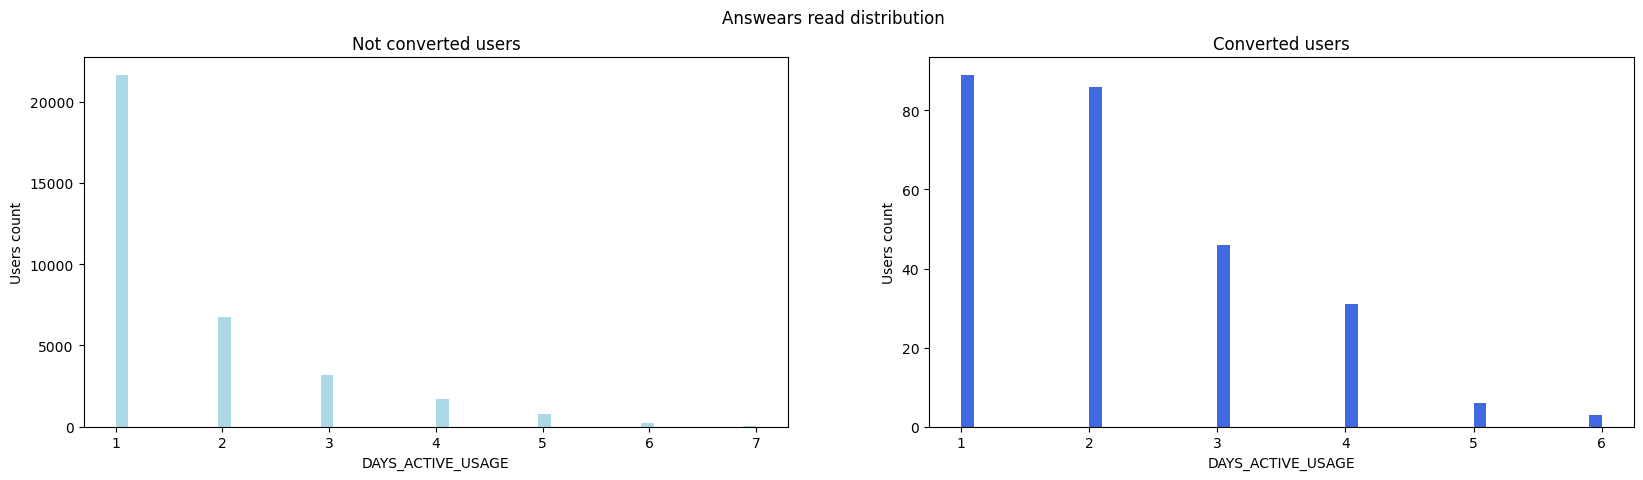

In [11]:
summary_for_metric('USER_CONVERTED_TO_TRIAL', 'DAYS_ACTIVE_USAGE')

#### ***************************************************************************************************************************************************************************************************
#### Calculating share of users that visited Brainly only once in analysed period

In [12]:

df['IF_ONLY_USED_ONCE'] = np.where(df['DAYS_ACTIVE_USAGE'] == 1, 'used once', 'used many times')

df_group = df.groupby(['USER_CONVERTED_TO_TRIAL', 'IF_ONLY_USED_ONCE']).USER_PSEUDO_ID.agg(['count'])

df_group['% users count'] = df_group['count'] / df_group.groupby('USER_CONVERTED_TO_TRIAL')['count'].transform('sum')
df_group.rename(columns={'count':'users count'}, inplace=True)
    
display(df_group.style \
  .format({'% users count':'{:.2%}'}, 
          thousands=","
         ))

## ***************************************************************************************************************************************************************************************************
## Separating segment of users that converted in first 7 days from their first visit

#### Calculationg segments depending of the period when user converted

In [13]:

print('\033[1mUser ever converted to trial:\033[0m')
calculate_counts('USER_CONVERTED_TO_TRIAL')

print('\n\n', '\033[1mUser converted to trial in first 7 days:\033[0m')
calculate_counts('USER_CONVERTED_TO_TRIAL_IN7D')

User ever converted to trial:


,users count,answears read sum,% users count,% answears read
USER_CONVERTED_TO_TRIAL,,,,
0,"34,372","288,735",99.25%,97.28%
1,261,"8,073",0.75%,2.72%




 User converted to trial in first 7 days:


,users count,answears read sum,% users count,% answears read
USER_CONVERTED_TO_TRIAL_IN7D,,,,
0,"34,435","289,713",99.43%,97.61%
1,198,"7,095",0.57%,2.39%


#### ***************************************************************************************************************************************************************************************************
#### Separating segment of users converted within first 7 days from first visit

In [14]:
conditions = [
    (df['USER_CONVERTED_TO_TRIAL'] == 1) & (df['USER_CONVERTED_TO_TRIAL_IN7D'] == 0),
    (df['USER_CONVERTED_TO_TRIAL'] == 1) & (df['USER_CONVERTED_TO_TRIAL_IN7D'] == 1),
    (df['USER_CONVERTED_TO_TRIAL'] == 0) & (df['USER_CONVERTED_TO_TRIAL_IN7D'] == 0)
]

values_txt = ['converted later', 'converted in first 7 days', 'not converted']
values_nb = [2, 1, 0]

df['USER_CONVERTED_TO_TRIAL_TXT'] = np.select(conditions, values_txt)
df['USER_CONVERTED_TO_TRIAL_NB'] = np.select(conditions, values_nb)
df_group = df.groupby(['USER_CONVERTED_TO_TRIAL_TXT']).ANSWERS_READ_SUM.agg(['count', 'sum'])
df_group['% users count'] = df_group['count'] / df_group['count'].sum()
df_group['% answers read'] = df_group['sum'] / df_group['sum'].sum()
df_group.rename(columns={'count':'users count', 'sum':'answers read sum'}, inplace=True)

display(df_group.style \
    .format({'% users count':'{:.2%}', 
           '% answers read':'{:.2%}'},
          thousands=","
         )
       )

print('\n\n', '\033[1mOnly for users that has converted:\033[0m')
df_group_conv = df.loc[df['USER_CONVERTED_TO_TRIAL_NB'] != 0].groupby(['USER_CONVERTED_TO_TRIAL_TXT']).ANSWERS_READ_SUM.agg(['count', 'sum'])
df_group_conv['% users count'] = df_group_conv['count'] / df_group_conv['count'].sum()
df_group_conv['% answers read'] = df_group_conv['sum'] / df_group_conv['sum'].sum()
df_group_conv.rename(columns={'count':'users count', 'sum':'answers read sum'}, inplace=True)

display(df_group_conv.style \
    .format({'% users count':'{:.2%}', 
           '% answers read':'{:.2%}'},
          thousands=","
         )
       )

,users count,answers read sum,% users count,% answers read
USER_CONVERTED_TO_TRIAL_TXT,,,,
converted in first 7 days,198,"7,095",0.57%,2.39%
converted later,63,978,0.18%,0.33%
not converted,"34,372","288,735",99.25%,97.28%




 Only for users that has converted:


,users count,answers read sum,% users count,% answers read
USER_CONVERTED_TO_TRIAL_TXT,,,,
converted in first 7 days,198,"7,095",75.86%,87.89%
converted later,63,978,24.14%,12.11%


#### ***************************************************************************************************************************************************************************************************
#### Distribution stats for new segments

In [15]:
df.groupby('USER_CONVERTED_TO_TRIAL_TXT')['ANSWERS_READ_SUM'].describe()\
    .style.format(precision=0, thousands=",")

,count,mean,std,min,25%,50%,75%,max
USER_CONVERTED_TO_TRIAL_TXT,,,,,,,,
converted in first 7 days,198,36,22,0,25,33,48,125
converted later,63,16,13,0,6,14,25,59
not converted,"34,372",8,23,0,0,1,7,"1,002"


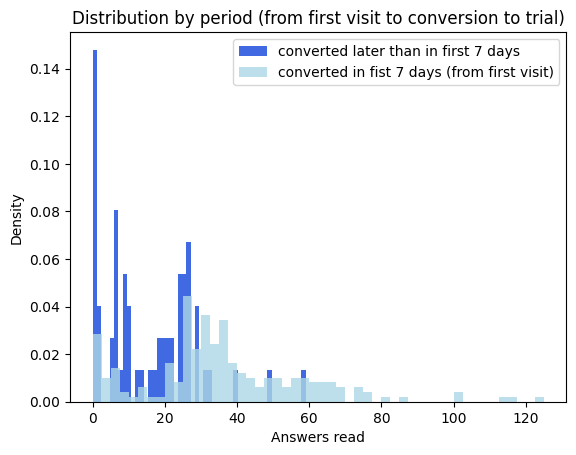

In [16]:
conv_in7d = df.loc[df['USER_CONVERTED_TO_TRIAL_NB'] == 1, 'ANSWERS_READ_SUM']
conv_later = df.loc[df['USER_CONVERTED_TO_TRIAL_NB'] == 2, 'ANSWERS_READ_SUM']

# plotting density histograms for converted users by period of conversion
plt.hist(conv_later, label='converted later than in first 7 days', density=True, color='royalblue', alpha=1, bins=50)
plt.hist(conv_in7d, label='converted in fist 7 days (from first visit)', density=True, color='lightblue', alpha=0.8, bins=50)

plt.title('Distribution by period (from first visit to conversion to trial)')
plt.xlabel('Answers read')
plt.ylabel('Density')

plt.legend()

plt.show()

#### ***************************************************************************************************************************************************************************************************
#### Plotting density histograms for converted and not converted users on separate charts

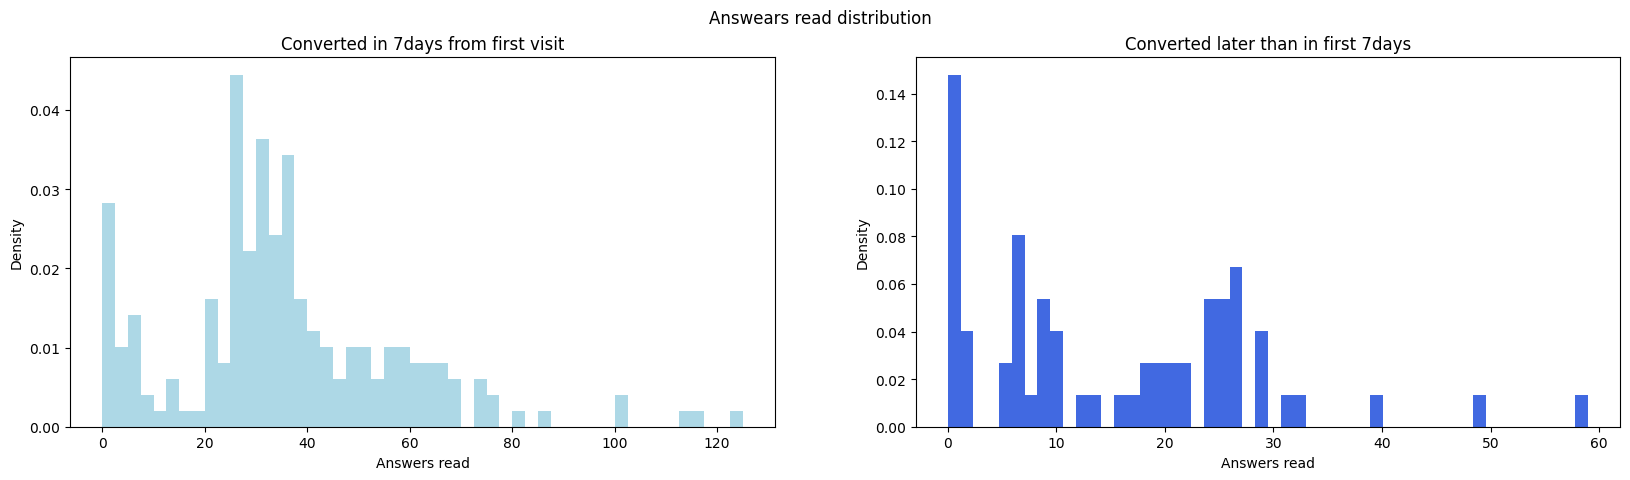

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.suptitle('Answears read distribution')

ax1.hist(conv_in7d, label='converted in first 7 days (from first visit)', density=True, color='lightblue', bins=50)
ax2.hist(conv_later, label='converted later than in first 7 days', density=True, color='royalblue', bins=50)

ax1.set_title('Converted in 7days from first visit')
ax2.set_title('Converted later than in first 7days')

ax1.set_xlabel('Answers read')
ax2.set_xlabel('Answers read')
ax1.set_ylabel('Density')
ax2.set_ylabel('Density')

plt.show()